In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
from utils import get_ray_directions, get_rays
import os
import json
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import Tuple
import lightning as L
from rendering import rendering

from dataset import LegoDataset, LegoDataModule
from model import Nerf

In [2]:
lego_dataset = LegoDataset(
    root_dir="dataset/lego/", split="test", img_shape=(200, 200)
)

In [10]:
train_dataloader = DataLoader(
    torch.cat(
        (
            lego_dataset.all_rays_origin.type(torch.float),
            lego_dataset.all_rays_direction.type(torch.float),
            lego_dataset.all_rgbs.type(torch.float),
        ),
        dim=1,
    ),
    batch_size=1024,
    num_workers=3,
    shuffle=True,
)

image_1_4 = int(lego_dataset.img_shape[0] * (1 / 4))
image_3_4 = int(lego_dataset.img_shape[0] * (3 / 4))
warmup_dataloader = DataLoader(
    torch.cat(
        (
            lego_dataset.all_rays_origin.reshape(
                len(lego_dataset),
                lego_dataset.img_shape[0],
                lego_dataset.img_shape[1],
                3,
            )[:, image_1_4:image_3_4, image_1_4:image_3_4, :]
            .reshape(-1, 3)
            .type(torch.float),
            lego_dataset.all_rays_direction.reshape(
                len(lego_dataset),
                lego_dataset.img_shape[0],
                lego_dataset.img_shape[1],
                3,
            )[:, image_1_4:image_3_4, image_1_4:image_3_4, :]
            .reshape(-1, 3)
            .type(torch.float),
            lego_dataset.all_rgbs.reshape(
                len(lego_dataset),
                lego_dataset.img_shape[0],
                lego_dataset.img_shape[1],
                3,
            )[:, image_1_4:image_3_4, image_1_4:image_3_4, :]
            .reshape(-1, 3)
            .type(torch.float),
        ),
        dim=1,
    ),
    batch_size=1024,
    num_workers=3,
    shuffle=True,
)

In [11]:
def training(
    model, optimizer, scheduler, dataloader, tn, tf, nb_bins, nb_epochs, device="cpu"
):

    training_loss = []

    progress_bar = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
    )

    for epoch in range(nb_epochs):
        progress_bar.set_description(f"Training Epoch: {epoch}")
        for idx, batch in progress_bar:
            origin = batch[:, :3].to(device)
            direction = batch[:, 3:6].to(device)

            target = batch[:, 6:].to(device)

            prediction = rendering(model, origin, direction, tn, tf, nb_bins, device)

            loss = ((prediction - target) ** 2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({"loss": loss.item()})
            training_loss.append(loss.item())

        scheduler.step()

        torch.save(model.cpu(), "models/model_nerf")
        model.to(device)

In [1]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# hyperparams
tn = 2.0
tf = 6.0
nb_epochs = 16
learning_rate = 1e-3
gamma = 0.5
nb_bins = 100

model = Nerf().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[2, 4, 8], gamma=gamma
)


# warmup on 1 epoch
training_loss = training(
    model, optimizer, scheduler, warmup_dataloader, tn, tf, nb_bins, 1, device
)
plt.plot(training_loss)
plt.show()

# training_loss = training(model, optimizer, scheduler, train_dataloader, tn, tf, nb_bins, nb_epochs, device)
# plt.plot(training_loss)
# plt.show()

NameError: name 'torch' is not defined

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nerf_model = torch.load('models/model_nerf').to(device)
nerf_model.eval()

# hyperparams
tn = 2.0
tf = 6.0
nb_epochs = 16
learning_rate = 1e-3
gamma = 0.5
nb_bins = 100

/home/stanley/Documents/shid/nerf_pytorch_lightning/utils.py:84: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


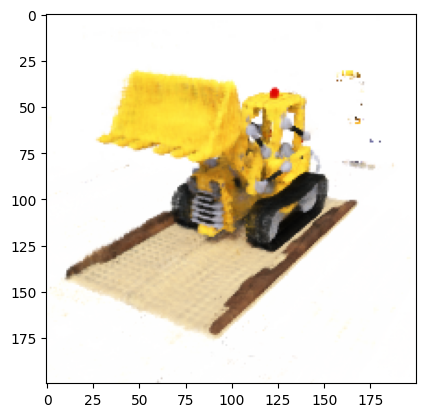

In [4]:
from utils import test
for idx in range(55, 60):
    img, mse, psnr = test(
    nerf_model,
    lego_dataset[idx]['rays_origin'].reshape(-1, 3).to(device).type(torch.float),
    lego_dataset[idx]['rays_direction'].reshape(-1, 3).to(device).type(torch.float),
    tn,
    tf,
    image_index=idx,
    nb_bins=100,
    chunk_size=20,
    height=lego_dataset.img_shape[0],
    width=lego_dataset.img_shape[1],
    target=lego_dataset[idx]['rgbs'].numpy(),
    outputs_dir='nerf_testbruh',
    title=False
)
